# Binary Human-Written vs Machine-Generated Text Classification

### Imports

In [1]:
# Run this cell to install the required packages

#TODO: add all packages that need to be installed in colab
# !pip install ipywidgets   #TODO: test if ipywidgets works also in colab or if must use @param etc.

In [19]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from nltk.tokenize import word_tokenize

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from ipywidgets import interact

from lightning import LightningModule
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy, F1Score

import evaluate
from transformers import AutoTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification

## Data Loading

In [2]:
train_df = pd.read_json(path_or_buf='./data/subtaskA_train_monolingual.jsonl', lines=True)
train_df.set_index('id',inplace=True)

val_df = pd.read_json(path_or_buf='./data/subtaskA_dev_monolingual.jsonl', lines=True)
val_df.set_index('id',inplace=True)

test_df = pd.read_json(path_or_buf='./data/subtaskA_test_monolingual.jsonl', lines=True)
test_df.set_index('id',inplace=True)

In [3]:
train_df.head()

,text,label,model,source
id,,,,
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow


In [4]:
val_df.head()

,text,label,model,source
id,,,,
0,Giving gifts should always be enjoyable. Howe...,1,bloomz,wikihow
1,Yveltal (Japanese: ユベルタル) is one of the main a...,1,bloomz,wikihow
2,If you'd rather not annoy others by being rude...,1,bloomz,wikihow
3,If you're interested in visiting gravesite(s) ...,1,bloomz,wikihow
4,The following are some tips for becoming succe...,1,bloomz,wikihow


In [5]:
test_df.head()

,text,label
id,,
0,"Today, many adults or teenage drivers are hook...",0
1,"The automobile, since its advent, has revoluti...",1
2,One policy that could potentially improve aca...,1
3,Title: Navigating the Road Ahead: The Case for...,1
4,Have you ever woken up in the morning and wish...,0


## Data exploration

In [6]:
@interact(i=(0, len(train_df)-1, 1))
def print_datapoint(i):
    return train_df.loc[i]

interactive(children=(IntSlider(value=59878, description='i', max=119756), Output()), _dom_classes=('widget-in…

In [8]:
@interact(i=(0, len(val_df)-1, 1))
def print_datapoint(i):
    return val_df.loc[i]

interactive(children=(IntSlider(value=2499, description='i', max=4999), Output()), _dom_classes=('widget-inter…

In [9]:
@interact(i=(0, len(test_df)-1, 1))
def print_datapoint(i):
    return test_df.loc[i]

interactive(children=(IntSlider(value=17135, description='i', max=34271), Output()), _dom_classes=('widget-int…

In [7]:
def print_stats(df, name):
    print(f"Stats for {name} data:")
    print(f"Dataset size: {len(df)}")
    print(f"Percentage of texts labeled as 1s (machine generated): {len(df[df['label'] == 1])/len(df)*100:.2f}% \n")

In [8]:
print_stats(train_df, "training")
print_stats(val_df, "validation")
print_stats(test_df, "test")

Stats for training data:
Dataset size: 119757
Percentage of texts labeled as 1s (machine generated): 47.10% 

Stats for validation data:
Dataset size: 5000
Percentage of texts labeled as 1s (machine generated): 50.00% 

Stats for test data:
Dataset size: 34272
Percentage of texts labeled as 1s (machine generated): 52.52% 



### Plots

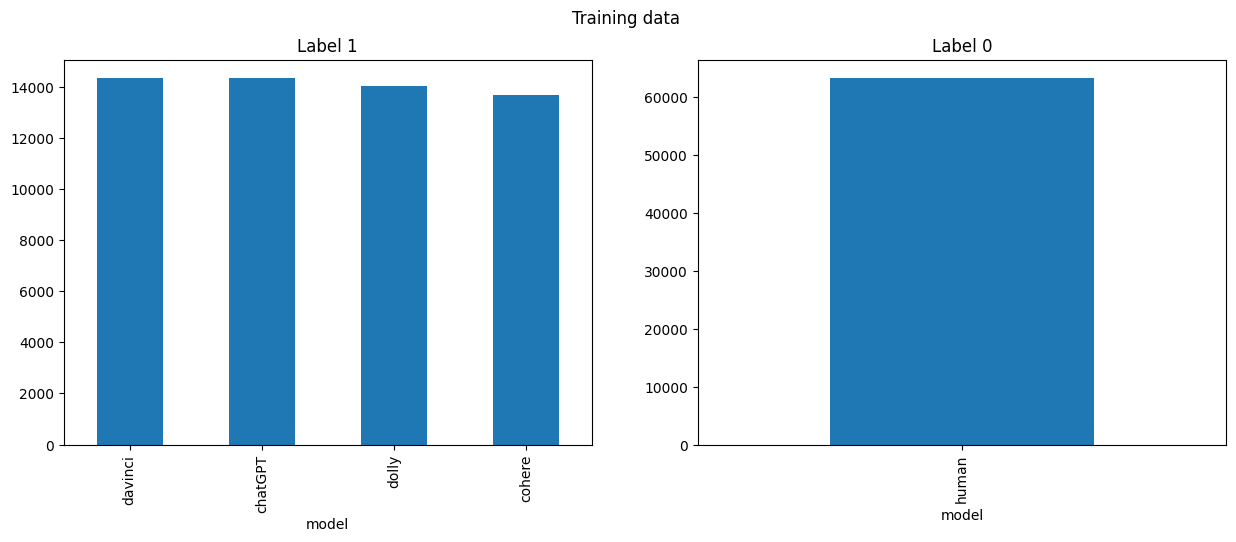

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Training data')
train_df[train_df['label'] == 1]['model'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
train_df[train_df['label'] == 0]['model'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

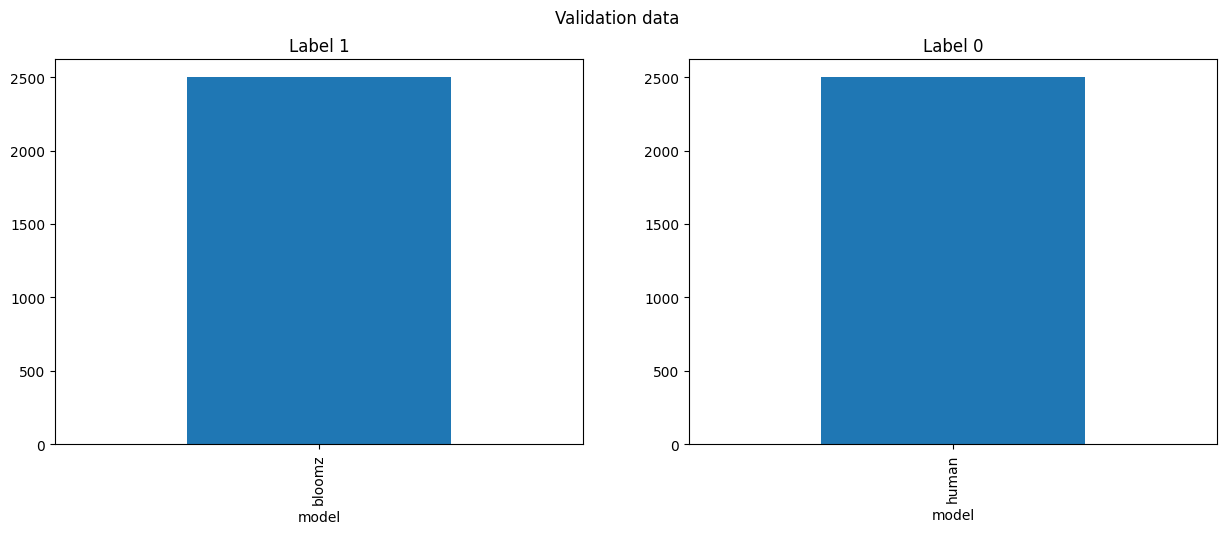

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Validation data')
val_df[val_df['label'] == 1]['model'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
val_df[val_df['label'] == 0]['model'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

The validation data contains text generated from a different LLM, bloomz, not present in the models that generated texts for the training data

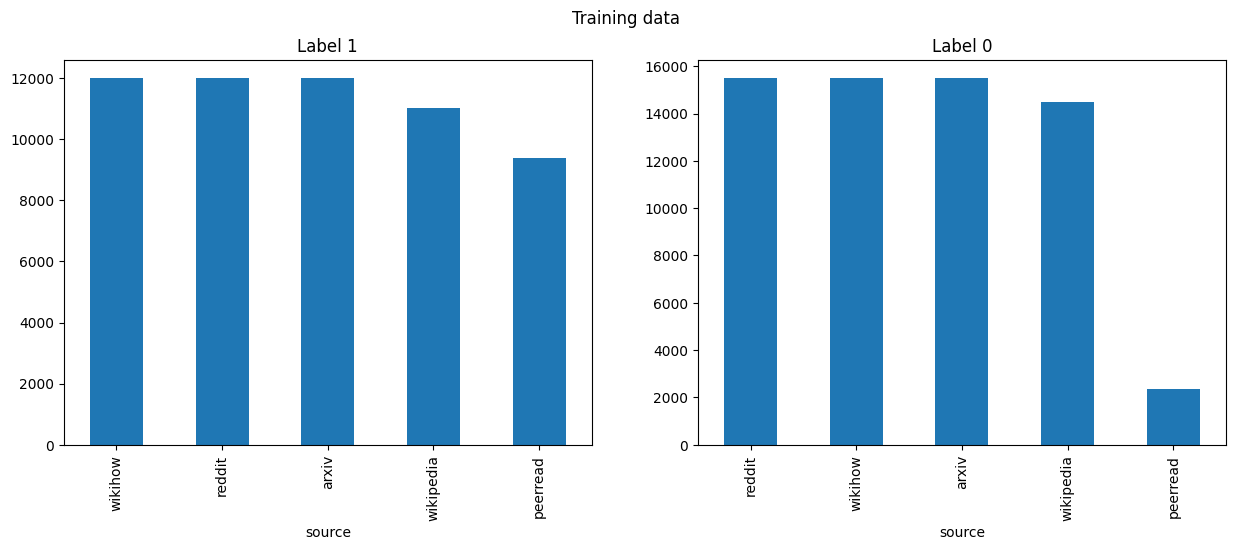

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Training data')
train_df[train_df['label'] == 1]['source'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
train_df[train_df['label'] == 0]['source'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

In [14]:
# TODO: what to do with the fact that we have much less peerread in the human written data??? Let's see how the model performs on pearread data 
# (it should be better in validation bcs unbalanced towards a class, but worse in validation bcs balanced, see below)

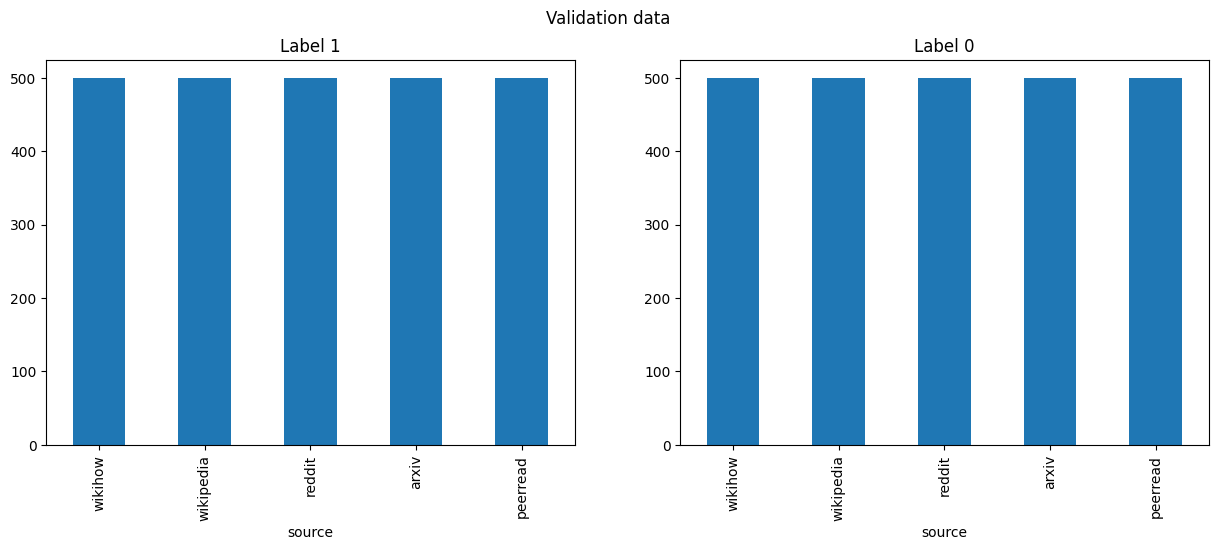

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Validation data')
val_df[val_df['label'] == 1]['source'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
val_df[val_df['label'] == 0]['source'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

The training and validation datasets are pretty balanced with respect to the fields "model" and "source".

We ignore these two in the following steps (as model would be only useful for a harder multiclass classification, source could be optionally passed to the model [TODO: try] to give more context) but keep them in the data to look for insights in the error analysis phase.

In [16]:
# TODO: probably should use BERTTokenizer as we will use that later, try with it

train_df['word_count'] = train_df['text'].apply(lambda text: len(word_tokenize(text)))
val_df['word_count'] = val_df['text'].apply(lambda text: len(word_tokenize(text)))
test_df['word_count'] = test_df['text'].apply(lambda text: len(word_tokenize(text)))

In [17]:
train_df.head()

,text,label,model,source,word_count
id,,,,,
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,487
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,813
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,1041
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,942
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,652


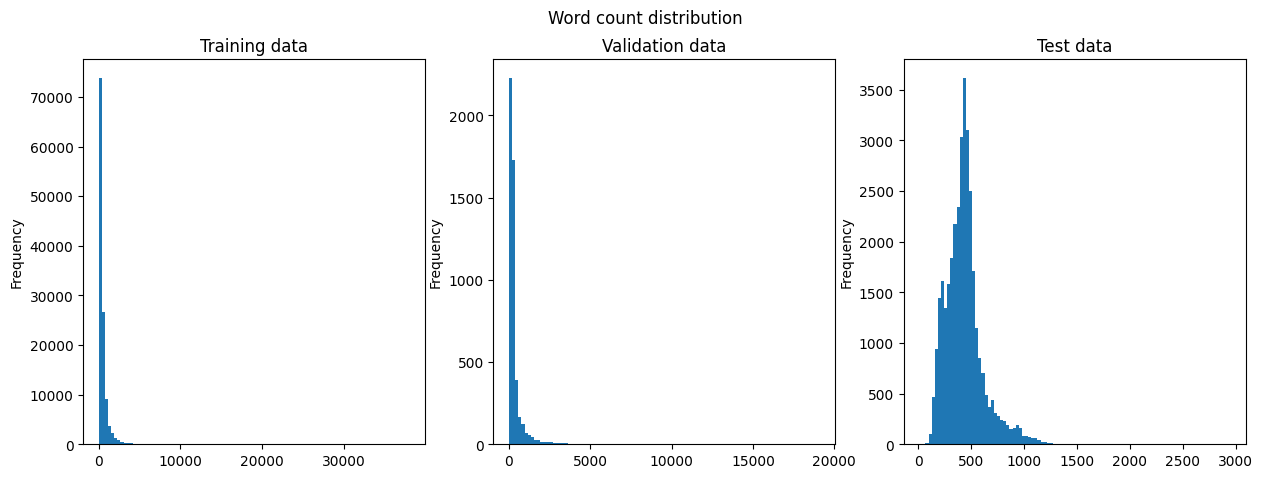

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

fig.suptitle('Word count distribution')
train_df['word_count'].plot(kind='hist', bins=100, ax=axes[0], title='Training data');
val_df['word_count'].plot(kind='hist', bins=100, ax=axes[1], title='Validation data');
test_df['word_count'].plot(kind='hist', bins=100, ax=axes[2], title='Test data');

Plot considering 99.57% of the training data and 99.62% of the test data


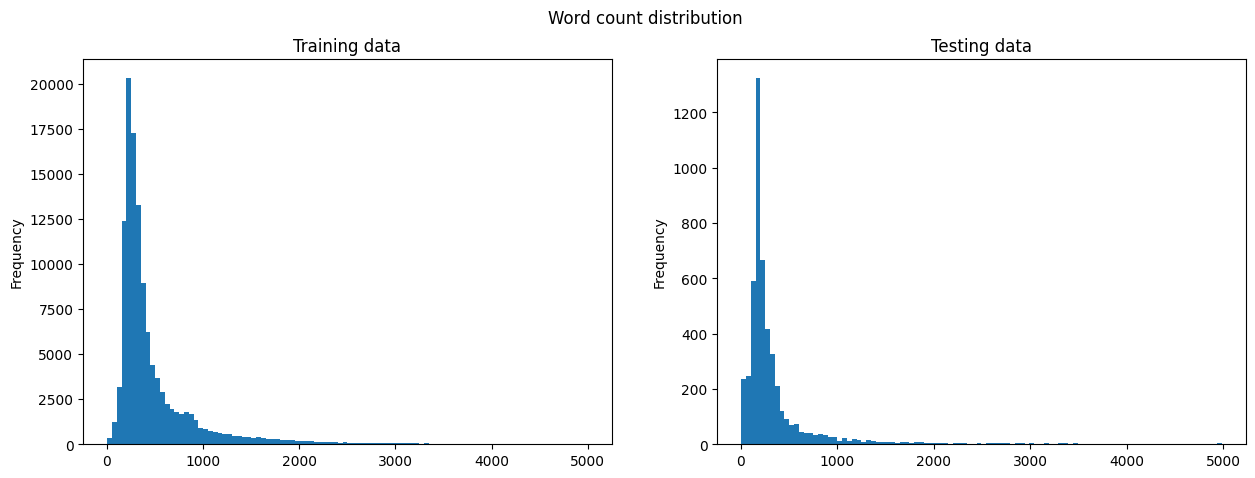

In [45]:
# Let's consider for a moment only the data below a certain threshold length (5000) for a more informative plot
print(f"""
      Plot considering {len(train_df[train_df['word_count'] < 5000]) / len(train_df) * 100 :.2f}% of the training data, 
      {len(val_df[val_df['word_count'] < 5000]) / len(val_df) * 100 :.2f}% of the validation data
      and {len(test_df[test_df['word_count'] < 5000]) / len(test_df) * 100 :.2f}% of the test data.""")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Word count distribution')
train_df[train_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[0], title='Training data');
val_df[val_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[1], title='Validation data');
test_df[test_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[1], title='Test data');

In [28]:
print("Word count statistics for training set:")
print(train_df['word_count'].describe())

print("\n")
print("Word count statistics for validation set:")
print(val_df['word_count'].describe())

print("\n")
print("Word count statistics for test set:")
print(test_df['word_count'].describe())

Word count statistics for training set:


KeyError: 'word_count'

Training and testing data are similar, or at least compatible, in terms of word counts of the texts, with test data having a noticably smaller word count

In [47]:
train_df.drop(columns='word_count', inplace=True)
val_df.drop(columns='word_count', inplace=True)
test_df.drop(columns='word_count', inplace=True)

In [48]:
# TODO: more analysis of the different vocabularies of the different models and sources? of the vocabularies in general?

## Data preparation

In [33]:
class TextDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'text': self.transform(row['text']) if self.transform else row['text'],
            'label': row['label']
        }

In [13]:
bert_model_name = 'google/bert_uncased_L-2_H-128_A-2' #TODO: try 'google/bert_uncased_L-2_H-128_A-2' (TinyBert) e 'distilbert-base-uncased' con DistilBertForSequenceClassification e AutoTokenizer

In [37]:
BERT_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

def preprocess_function(text):
    return BERT_tokenizer(text, truncation=True, padding=False)

train_dataset = TextDataset(train_df, transform=preprocess_function)
val_dataset = TextDataset(val_df, transform=preprocess_function)
test_dataset = TextDataset(test_df, transform=preprocess_function)

In [52]:
def padding_collate_fn(batch):
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    return BERT_tokenizer.pad(texts, return_tensors='pt', padding=True), torch.tensor(labels)

In [53]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=padding_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=padding_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=padding_collate_fn)

## Metrics

The official evaluation metric for Subtask A is **accuracy**. In the [challenge website](https://www.codabench.org/competitions/1752/#/pages-tab) the scorer also reports **macro-F1** and **micro-F1**.

Since it's a binary classification problem though, we limited ourselves to computing **F1-Score**, as it didn't make sense to consider the macro- and micro- interpretations of the metrics (also because the two classes are balanced). (TODO: in realtà le classi non sono perfettamente bilanciate, quindi magari riguardare le definizioni di micro e macro, che non me le ricordo)

## Models

### Baseline

#### BERT baseline on two different settings: frozen backbone and fully fine-tuned backbone

In [55]:
id2label = {0: "human", 1: "machine"}
label2id = {"human": 0, "machine": 1}

In [56]:
class BERTBaseline(LightningModule):
    def __init__(self, bert_model_name, lr_backbone, lr_classifier):
        super().__init__()
        self.save_hyperparameters()

        self.model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=1, id2label=id2label, label2id=label2id)
        self.lr_backbone = lr_backbone
        self.lr_classifier = lr_classifier

        # if lr_backbone == 0, then the backbone is considered frozen
        if lr_backbone == 0:
            for param in self.model.base_model.parameters():
                param.requires_grad = False

        # TODO: add metrics. Use log(on_epoch=True) to accumulate and log the metric at the end of the epoch 
        self.train_acc = Accuracy(task='binary') #TODO: test it if it works this way
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

        self.train_f1 = F1Score(task='binary')
        self.val_f1 = F1Score(task='binary')
        self.test_f1 = F1Score(task='binary')
            
    def forward(self, x):
        return self.model(**x)
    
    def configure_optimizers(self):
        if self.lr_backbone == 0:
            optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=self.lr_classifier)
        else:
            optimizer = torch.optim.Adam([
                {'params': self.model.base_model.parameters(), 'lr': self.lr_backbone},
                {'params': self.model.classifier.parameters(), 'lr': self.lr_classifier}
            ])
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits #TODO: check if this is the right way to get the logits
        loss = nn.BCEWithLogitsLoss()(logits, y)

        y_hat = torch.zeros_like(logits)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        acc = self.train_acc(y_hat, y)
        f1 = self.train_f1(y_hat, y)
        self.log_dict({'train_loss': loss, 'train_acc': acc, 'train_f1': f1, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, 
            logger=True, on_step=False, reduce_fx="mean")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits
        loss = nn.BCEWithLogitsLoss()(logits, y)

        y_hat = torch.zeros_like(logits)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        acc = self.val_acc(y_hat, y)
        f1 = self.val_f1(y_hat, y)
        self.log_dict({'val_loss': loss, 'val_acc': acc, 'val_f1': f1, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, 
            logger=True, on_step=False, reduce_fx="mean")
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits
        loss = nn.BCEWithLogitsLoss()(logits, y)

        y_hat = torch.zeros_like(logits)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        acc = self.test_acc(y_hat, y)
        f1 = self.test_f1(y_hat, y)
        self.log_dict({'test_loss': loss, 'test_acc': acc, 'test_f1': f1, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, 
            logger=True, on_step=False, reduce_fx="mean")
        return loss

In [ ]:
class BERTBaseline2(LightningModule):
    def __init__(self, bert_model_name, lr_backbone, lr_classifier):
        super().__init__()
        self.save_hyperparameters()

        self.model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=2, id2label=id2label, label2id=label2id)
        self.lr_backbone = lr_backbone
        self.lr_classifier = lr_classifier

        # if lr_backbone == 0, then the backbone is considered frozen
        if lr_backbone == 0:
            for param in self.model.base_model.parameters():
                param.requires_grad = False

        # TODO: add metrics. Use log(on_epoch=True) to accumulate and log the metric at the end of the epoch 
        self.train_acc = Accuracy(task='binary') #TODO: test it if it works this way
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

        self.train_f1 = F1Score(task='binary')
        self.val_f1 = F1Score(task='binary')
        self.test_f1 = F1Score(task='binary')
            
    def forward(self, x):
        return self.model(**x)
    
    def configure_optimizers(self):
        if self.lr_backbone == 0:
            optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=self.lr_classifier)
        else:
            optimizer = torch.optim.Adam([
                {'params': self.model.base_model.parameters(), 'lr': self.lr_backbone},
                {'params': self.model.classifier.parameters(), 'lr': self.lr_classifier}
            ])
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits #TODO: check if this is the right way to get the logits
        loss = torch.nn.functional.cross_entropy(logits, y)

        y_hat = torch.argmax(logits, dim=1)
        acc = self.train_acc(y_hat, y)
        f1 = self.train_f1(y_hat, y)
        self.log_dict({'train_loss': loss, 'train_acc': acc, 'train_f1': f1, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, 
            logger=True, on_step=False, reduce_fx="mean")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits
        loss = torch.nn.functional.cross_entropy(logits, y)

        y_hat = torch.argmax(logits, dim=1)
        acc = self.val_acc(y_hat, y)
        f1 = self.val_f1(y_hat, y)
        self.log_dict({'val_loss': loss, 'val_acc': acc, 'val_f1': f1, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, 
            logger=True, on_step=False, reduce_fx="mean")
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits
        loss = torch.nn.functional.cross_entropy(logits, y)

        y_hat = torch.argmax(logits, dim=1)
        acc = self.test_acc(y_hat, y)
        f1 = self.test_f1(y_hat, y)
        self.log_dict({'test_loss': loss, 'test_acc': acc, 'test_f1': f1, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, 
            logger=True, on_step=False, reduce_fx="mean")
        return loss

### Our models

## Training

TEST

In [ ]:
logs_path = Path.cwd() / "logs" / "lightning_logs"

seeds = [42]

epochs = 10     #TODO: increse?

train = True

In [ ]:
model_classes = [BERTBaseline, BERTBaseline2]
model_names = ["bert_frozen", "bert_frozen2"]
hyperparameters = [
    {'bert_model_name': bert_model_name, 'lr_backbone': 0, 'lr_classifier': 1e-3},
    {'bert_model_name': bert_model_name, 'lr_backbone': 0, 'lr_classifier': 1e-3}    #TODO: check backbone lr, should it be 1/10 of paper?
]

if train == True:
    for model_class, model_name, hyperparameter in zip(model_classes, model_names, hyperparameters):
        for seed in seeds:
            print(f"====Training {model_name} with seed {seed}====")
            seed_everything(seed)

            model = model_class(**hyperparameter)

            logger = TensorBoardLogger(logs_path, name=f"{model_name}_seed{seed}")
            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath=None,
                filename=f'{model_name}-seed={seed}-backbone={bert_model_name}' + '-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}',
                save_top_k=1,
            )
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=3,
                verbose=True,
                mode='min'
            )

            trainer = Trainer(
                max_epochs=epochs, 
                logger=logger, 
                log_every_n_steps=1, 
                callbacks=[checkpoint_callback, early_stop_callback], 
                deterministic=True
            )

            trainer.fit(model, train_dataloader, val_dataloader)
else:
    print("Skipping training.")

FINE TEST

In [ ]:
logs_path = Path.cwd() / "logs" / "lightning_logs"

seeds = [42, 24, 79, 3, 151]

epochs = 10     #TODO: increse?

train = False

In [ ]:
model_classes = [BERTBaseline, BERTBaseline]
model_names = ["bert_frozen", "bert_finetuned"]
hyperparameters = [
    {'bert_model_name': bert_model_name, 'lr_backbone': 0, 'lr_classifier': 1e-3},
    {'bert_model_name': bert_model_name, 'lr_backbone': 1e-5, 'lr_classifier': 1e-3}    #TODO: check backbone lr, should it be 1/10 of paper?
]

if train == True:
    for model_class, model_name, hyperparameter in zip(model_classes, model_names, hyperparameters):
        for seed in seeds:
            print(f"====Training {model_name} with seed {seed}====")
            seed_everything(seed)

            model = model_class(**hyperparameter)

            logger = TensorBoardLogger(logs_path, name=f"{model_name}_seed{seed}")
            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath=None,
                filename=f'{model_name}-seed={seed}-backbone={bert_model_name}' + '-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}',
                save_top_k=1,
            )
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=3,
                verbose=True,
                mode='min'
            )

            trainer = Trainer(
                max_epochs=epochs, 
                logger=logger, 
                log_every_n_steps=1, 
                callbacks=[checkpoint_callback, early_stop_callback], 
                deterministic=True
            )

            trainer.fit(model, train_dataloader, val_dataloader)
else:
    print("Skipping training.")

## Evaluation

## Error analysis